<a href="https://colab.research.google.com/github/Warukunai/AI/blob/main/Finetune_Chinese_Weibo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利用中文微博評價資料進行Bert微調


In [2]:
! pip install transformers datasets
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00


## 下載微博評價資料

In [3]:
!wget https://github.com/shhuangmust/AI/raw/refs/heads/113-1/weibo_senti_100k.csv

--2025-01-06 21:43:40--  https://github.com/shhuangmust/AI/raw/refs/heads/113-1/weibo_senti_100k.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shhuangmust/AI/refs/heads/113-1/weibo_senti_100k.csv [following]
--2025-01-06 21:43:40--  https://raw.githubusercontent.com/shhuangmust/AI/refs/heads/113-1/weibo_senti_100k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19699818 (19M) [application/octet-stream]
Saving to: ‘weibo_senti_100k.csv’

weibo_senti_100k.cs 100%[===================>]  18.79M   104MB/s    in 0.2s    

2025-01-06 21:43:43 (104 MB/s) - ‘weibo_senti_100k.csv’ saved [196

## 讀取Weibo資料集
- 共有119988筆資料

In [4]:
from datasets import load_dataset, DatasetDict

ds = load_dataset("csv", data_files="weibo_senti_100k.csv")
print(ds)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'review'],
        num_rows: 119988
    })
})


## 分割資料集
- 80%訓練(train)資料
- 10%測試(test)資料
- 10%驗證(valid)資料


In [5]:
train_testvalid = ds['train'].train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})


## 進行分詞

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-chinese")

def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Map:   0%|          | 0/95990 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

## 為簡化訓練，挑選10000筆作為訓練與測試資料

In [7]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000))
print(small_train_dataset)
print(small_eval_dataset)

Dataset({
    features: ['label', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})
Dataset({
    features: ['label', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})


## 列印一筆資料出來看

In [8]:
tokenized_datasets["train"][100]

{'label': 1,
 'review': '回复@EStella遥: [哈哈]喝不趴的，就是卧倒~~~~~~~~!//@EStella遥:回复@好书吧-老板的娘: @贰小?   阿姨自己酿的酒，肯定喝不趴你。。',
 'input_ids': [101,
  1726,
  1908,
  137,
  100,
  6898,
  131,
  138,
  1506,
  1506,
  140,
  1600,
  679,
  6640,
  4638,
  8024,
  2218,
  3221,
  1309,
  948,
  172,
  172,
  172,
  172,
  172,
  172,
  172,
  172,
  106,
  120,
  120,
  137,
  100,
  6898,
  131,
  1726,
  1908,
  137,
  1962,
  741,
  1416,
  118,
  5439,
  3352,
  4638,
  2023,
  131,
  137,
  6582,
  2207,
  136,
  7350,
  2007,
  5632,
  2346,
  7001,
  4638,
  6983,
  8024,
  5507,
  2137,
  1600,
  679,
  6640,
  872,
  511,
  511,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


## 本次微調需要得到正面/負面的判斷結果，因此挑選AutoModelForSequenceClassification
- 輸出結果為正面/負面，因此num_labels=2

In [9]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-chinese", num_labels=2)

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 利用TrainingArguments設定微調參數

In [10]:
from transformers import TrainingArguments
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer_chinese", evaluation_strategy="epoch")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 利用Trainer進行訓練
- 此處須輸入wandb key

In [11]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.103000,0.076767,0.979900
2,0.066700,0.090809,0.980400
3,0.059700,0.063319,0.982000


TrainOutput(global_step=3750, training_loss=0.08694337768554687, metrics={'train_runtime': 4199.4127, 'train_samples_per_second': 7.144, 'train_steps_per_second': 0.893, 'total_flos': 7893331660800000.0, 'train_loss': 0.08694337768554687, 'epoch': 3.0})

## 利用pipeline進行測試
- LABEL_0：負面
- LABEL_1：正面

In [12]:
from transformers import pipeline
pipe = pipeline("sentiment-analysis", model='test_trainer_chinese/checkpoint-3500', tokenizer=tokenizer)

Device set to use cuda:0


In [13]:
pipe("我喜歡這個產品")

[{'label': 'LABEL_1', 'score': 0.9996128678321838}]

## wandb訓練結果截圖

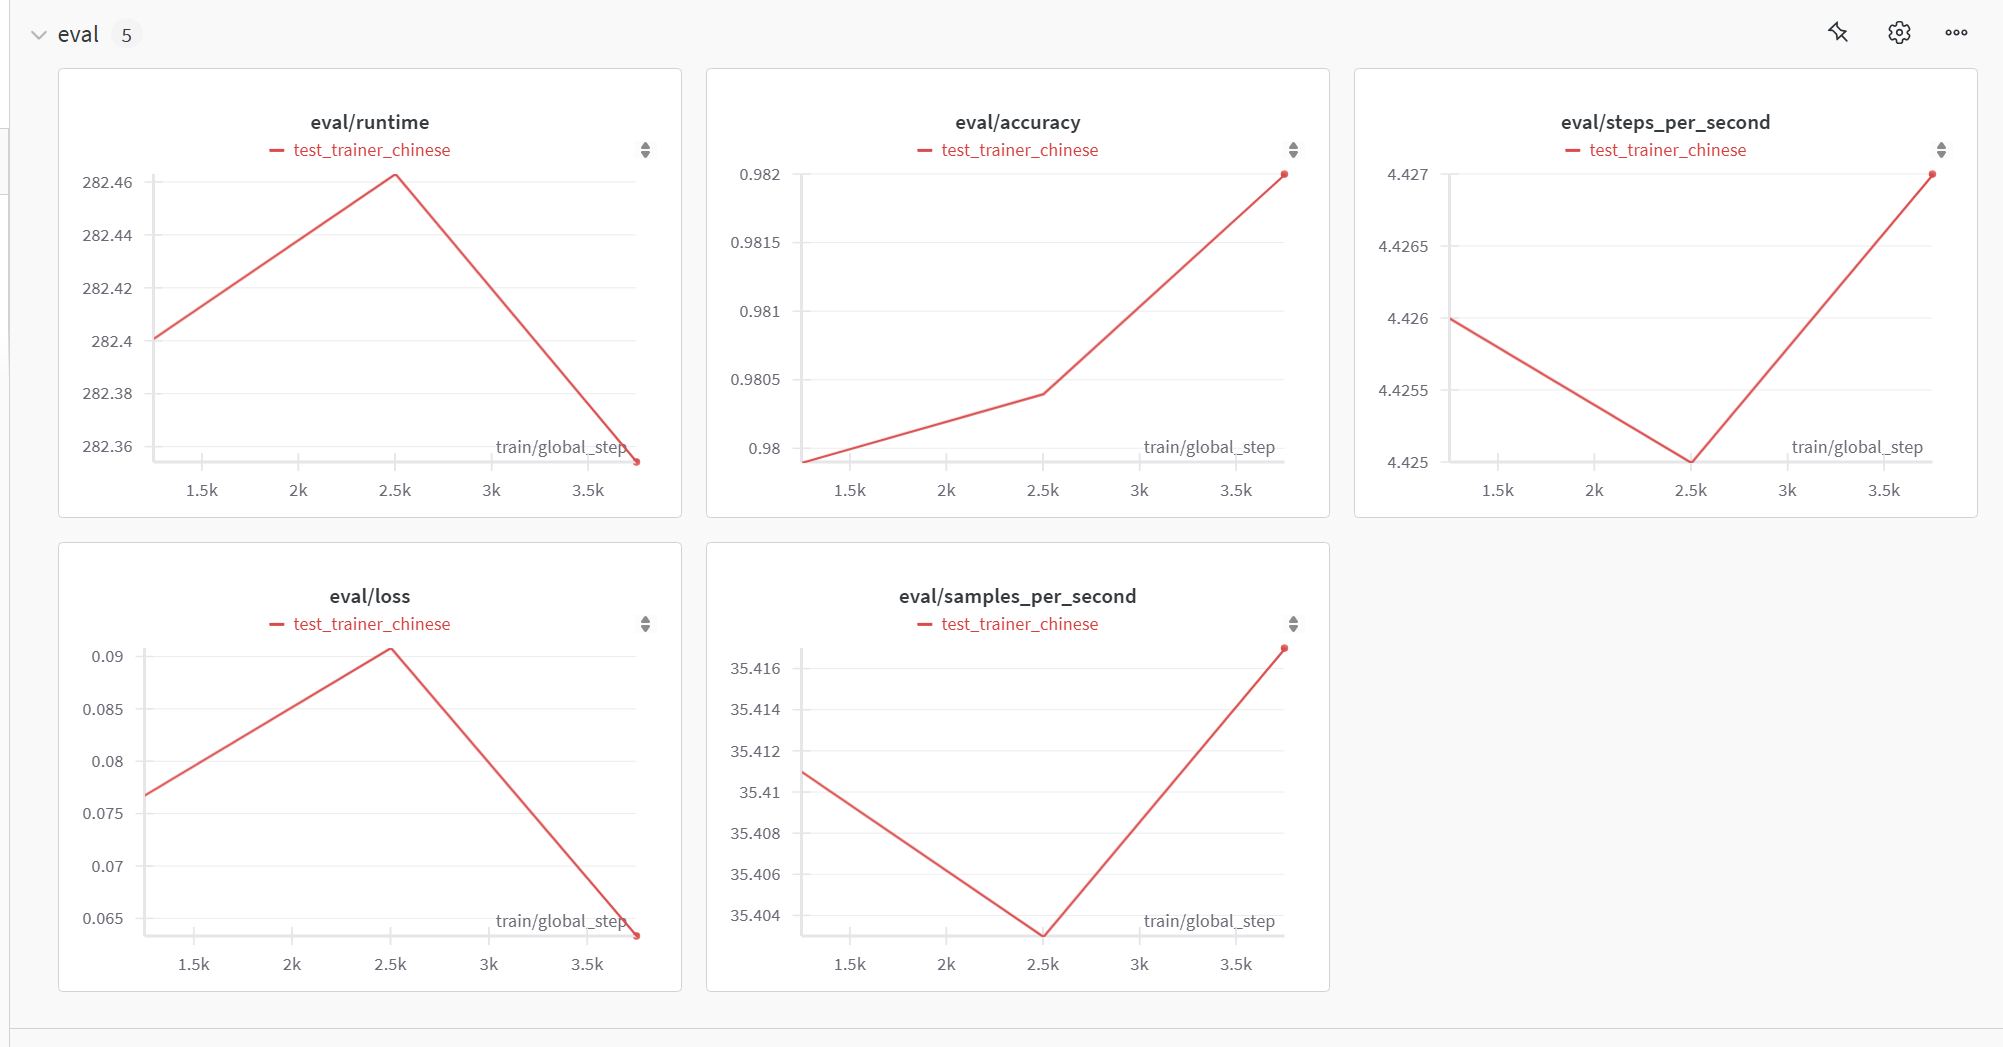

<a id='additional-resources'></a>